In [1]:
# Install required packages
!pip install transformers[torch] datasets -q
!pip install Pillow -q
!pip install torch torchvision -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 70.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 16.1.0 which is incompatible.
google-colab 1.0.0 requires requests==2.31.0, but you have request

Because we want to store the data and model imediately after training, we mount colab to Google Drive, and then move to the desired directory

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/IDEFICS2/

/content/drive/MyDrive/Colab Notebooks/IDEFICS2


#VGG - GPT2

In [ ]:
# Import required packages
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from torchvision import models
from datasets import load_dataset
import torchvision.transforms as transforms
import torch.optim as optim
from torch.nn.functional import cross_entropy
import matplotlib.pyplot as plt
from tqdm import tqdm

## Dataset Handling

In [ ]:
# Initialize tokenizer and set padding token
gpt2_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token

# Image transformations
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # VGG requires 224x224 images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom Dataset class
class DatasetProcessing(Dataset):
    def __init__(self, dataset, tokenizer, transform=None):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample = self.dataset[idx]
        image = sample['image']  # Assume this is already a PIL.Image object
        question = sample['question']
        answer = sample['answer']

        # Ensure image is in RGB format
        if image.mode != 'RGB':
            image = image.convert('RGB')

        if self.transform:
            image = self.transform(image)

        # Tokenize the question
        question_inputs = self.tokenizer(question, return_tensors="pt", padding='max_length', truncation=True, max_length=30)
        question_input_ids = question_inputs['input_ids'].squeeze(0)

        # Tokenize the answer
        answer_inputs = self.tokenizer(answer, return_tensors="pt", padding='max_length', truncation=True, max_length=30)
        answer_input_ids = answer_inputs['input_ids'].squeeze(0)

        return image, question_input_ids, answer_input_ids


# Load SLAKE dataset
dataset = load_dataset("mdwiratathya/SLAKE-vqa-english")
train_data = dataset['train']
val_data = dataset['validation']
test_data = dataset['test']

# Create DataLoader
train_dataset = DatasetProcessing(train_data, gpt2_tokenizer, image_transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = DatasetProcessing(val_data, gpt2_tokenizer, image_transform)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

test_dataset = DatasetProcessing(test_data, gpt2_tokenizer, image_transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# # VQA-RAD Dataset only has train and test set. If you want to use VQA-RAD dataset, use this section instead.
# # Load VQA-RAD dataset
# dataset = load_dataset("flaviagiammarino/vqa-rad")
# train_data = dataset['train']
# val_data = dataset['test']

# # Create DataLoader
# train_dataset = DatasetProcessing(train_data, gpt2_tokenizer, image_transform)
# train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# val_dataset = DatasetProcessing(val_data, gpt2_tokenizer, image_transform)
# val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## Model Architecture Definition

This is all from https://github.com/ab3llini/Transformer-VQA

In [ ]:
class CoAttention(nn.Module):
    def __init__(self, map_dim, hidden_dim, attention_dim=512):
        """
        :param map_dim: Number of maps (i.e. channels) in the used CNN. Usually map_dim = maps.shape[-1]
        :param hidden_dim: Size of  hidden layer of the language model. Usually hidden_size = hiddens.shape[-1]
        :param attention_dim: Dimension of the attention layers
        """
        super(CoAttention, self).__init__()
        # Set parameters
        self.map_dim = map_dim
        self.hidden_dim = hidden_dim
        self.attention_dim = attention_dim

        # Prepare linear layers
        self.map_linear = nn.Linear(in_features=self.map_dim, out_features=self.attention_dim)
        self.hidden_linear = nn.Linear(in_features=self.hidden_dim, out_features=self.attention_dim)
        self.co_att_linear = nn.Linear(in_features=self.map_dim, out_features=self.hidden_dim)
        self.rectified_linear = nn.Linear(in_features=self.attention_dim, out_features=1)
        self.pixel_softmax = nn.Softmax(dim=2)  # Make sure this is 2 and not 1. We softmax over the pixels!

        # Prepare the rectifier
        self.rectify = nn.ReLU()

    def forward(self, maps, hiddens):
        """
        Where the magic happens :)
        In this method we will use the hidden values of the used language model to
        generate masks (softmaps) over the maps coming from the used CNN.
        The procedure involves summations, pointwise multiplications and linear transformations.
        :param maps: The maps coming from the last layer of the used CNN. (batch_size, x, y, map_dim)
        :param hiddens: The hidden vector coming from the last transformer layer (batch_size, n_tokens, hidden_size)
        :return: co-attended vector (batch_size, n_tokens, hidden_size), softmap (batch_size, x * y, n_maps)
        Note: For performance reasons we do not reshape the softmap to a 2D representation. We leave it flattened.
        In case you need to plot it, first reshape it.
        """

        # Obtain basic information
        batch_size = maps.size(0)

        # Flatten each map from x, y to x * y, where x = n_rows, y = n_cols, [x, y] = pixel
        flattened_maps = maps.view(batch_size, -1, self.map_dim)

        # Go to attention space with linear layers
        map_linear_out = self.map_linear(flattened_maps)
        hidden_linear_out = self.hidden_linear(hiddens)

        # Make the two resulting vectors ready for pointwise multiplication
        # Add a fake dimension right after the batch size (accounts for tokens)
        map_linear_out = map_linear_out.unsqueeze(1)
        # Add a fake dimension after the number of tokens (accounts for pixels)
        hidden_linear_out = hidden_linear_out.unsqueeze(2)

        # Sum the two vectors -> (batch_size, n_tokens, x * y, map_dim)
        pointwise_sum = map_linear_out + hidden_linear_out

        # Rectify the result and get rid of negative values + help vanishing gradients
        rectified_sum = self.rectify(pointwise_sum)

        # Combine the maps channels together and prepare them for the softmax (batch_size, n_tokens, x * y)
        rectified_linear_out = self.rectified_linear(rectified_sum).squeeze(3)

        # Create the softmap using a softmax function over all the pixels (batch_size, n_tokens, x*y), x*y in [0,1]
        pixel_softmax_out = self.pixel_softmax(rectified_linear_out)

        # Pointwise multiply the softmap with the original maps (batch_size, n_tokens, x*y, map_dim)
        # Unsqueeze(1) to add a fake dimension to sum the maps over all the tokens
        # Unsqueeze(3) to add a fake dimension to sum the same vector to all the original maps
        pointwise_mul = flattened_maps.unsqueeze(1) * pixel_softmax_out.unsqueeze(3)

        # Sum the pixels together, in each map, to get a unified representation (batch_size, n_tokens, map_dim)
        pointwise_mul = pointwise_mul.sum(dim=2)

        # At this point we expand (or reduce) the resulting tensor to match the hidden one
        co_att_linear_out = self.co_att_linear(pointwise_mul)  # (batch_size, n_tokens, hidden)

        # We finally pointwise multiply the latter output with the original hidden tensor
        co_att_out = co_att_linear_out * hiddens

        # Return the computed tensors
        return co_att_out, pixel_softmax_out


class LightAttention(nn.Module):
    def __init__(self, map_dim, hidden_dim):
        """
        :param map_dim: Number of maps (i.e. channels) in the used CNN. Usually map_dim = maps.shape[-1]
        :param hidden_dim: Size of hidden layer of the language model. Usually hidden_size = hiddens.shape[-1]
        """
        super(LightAttention, self).__init__()
        # Set parameters
        self.map_dim = map_dim
        self.hidden_dim = hidden_dim

        # Prepare linear layers
        self.map_linear = nn.Linear(in_features=self.map_dim, out_features=self.hidden_dim)
        self.final_linear = nn.Linear(in_features=self.map_dim, out_features=self.hidden_dim)
        self.rectified_linear = nn.Linear(in_features=self.hidden_dim, out_features=1)
        self.pixel_softmax = nn.Softmax(dim=2)  # Make sure this is 2 and not 1. We softmax over the pixels!

        with torch.no_grad():
            self.final_linear.weight.copy_(torch.zeros((self.hidden_dim, self.map_dim)))


        # Prepare the rectifier
        self.rectify = nn.ReLU()

    def forward(self, maps, hiddens):
        """
        Where the magic happens :)
        In this method we will use the hidden values of the used language model to
        generate masks (softmaps) over the maps coming from the used CNN.
        The procedure involves summations, pointwise multiplications and linear transformations.
        :param maps: The maps coming from the last layer of the used CNN. (batch_size, x, y, map_dim)
        :param hiddens: The hidden vector coming from the last transformer layer (batch_size, n_tokens, hidden_size)
        :return: co-attended vector (batch_size, n_tokens, hidden_size), softmap (batch_size, x * y, n_maps)
        Note: For performance reasons we do not reshape the softmap to a 2D representation. We leave it flattened.
        In case you need to plot it, first reshape it.
        """

        # Obtain basic information
        batch_size = maps.size(0)

        # Flatten each map from x, y to x * y, where x = n_rows, y = n_cols, [x, y] = pixel
        flattened_maps = maps.view(batch_size, -1, self.map_dim)

        # Go to attention space with linear layers
        map_linear_out = self.map_linear(flattened_maps)

        # Make the two resulting vectors ready for pointwise multiplication
        # Add a fake dimension right after the batch size (accounts for tokens)
        map_linear_out = map_linear_out.unsqueeze(1)
        # Add a fake dimension after the number of tokens (accounts for pixels)
        hidden_linear_out = hiddens.unsqueeze(2)

        # Sum the two vectors -> (batch_size, n_tokens, x * y, map_dim)
        pointwise_sum = map_linear_out + hidden_linear_out

        # Rectify the result and get rid of negative values + help vanishing gradients
        rectified_sum = self.rectify(pointwise_sum)

        # Combine the maps channels together and prepare them for the softmax (batch_size, n_tokens, x * y)
        rectified_linear_out = self.rectified_linear(rectified_sum).squeeze(3)

        # Create the softmap using a softmax function over all the pixels (batch_size, n_tokens, x*y), x*y in [0,1]
        pixel_softmax_out = self.pixel_softmax(rectified_linear_out)

        # Pointwise multiply the softmap with the original maps (batch_size, n_tokens, x*y, map_dim)
        # Unsqueeze(1) to add a fake dimension to sum the maps over all the tokens
        # Unsqueeze(3) to add a fake dimension to sum the same vector to all the original maps
        pointwise_mul = flattened_maps.unsqueeze(1) * pixel_softmax_out.unsqueeze(3)

        # Sum the pixels together, in each map, to get a unified representation (batch_size, n_tokens, map_dim)
        pointwise_mul = pointwise_mul.sum(dim=2)

        # At this point we expand (or reduce) the resulting tensor to match the hidden one
        out = self.final_linear(pointwise_mul)  # (batch_size, n_tokens, hidden)

        # We finally pointwise multiply the latter output with the original hidden tensor
        out = out + hiddens

        # Return the computed tensors
        return out, pixel_softmax_out

class ModularGpt2(nn.Module):
    def __init__(self, emd_size=None):
        super(ModularGpt2, self).__init__()

        gpt2 = GPT2LMHeadModel.from_pretrained('gpt2')
        if emd_size:
            gpt2.resize_token_embeddings(emd_size)

        self.head = list(gpt2.children())[1]
        self.gpt2 = list(gpt2.children())[0]

    def show_params(self):
        for name, param in self.named_parameters():
            if param.requires_grad:
                print('Trainable : TRUE ->', name)
            else:
                print('Trainable : FALSE ->', name)

        print('Trainable parameters: {}'.format(sum(p.numel() for p in self.parameters() if p.requires_grad)))
        print('Total parameters: {}'.format(sum(p.numel() for p in self.parameters())))

    def forward(self, sequence):
        return self.head(self.gpt2(sequence)[0])

class VGGEncoder(nn.Module):

    def __init__(self, instance=models.vgg11(pretrained=True)):
        super(VGGEncoder, self).__init__()

        # Using pre-trained vgg
        vgg = instance

        # Remove the classifier
        modules = list(vgg.children())[:-1]

        # Keep only the network
        self.vgg = nn.Sequential(*modules)

    def forward(self, images):
        # outputs maps from vgg (512 channels average pooled @ 7x7)
        out = self.vgg(images)  # (batch_size, 512, 7, 7)
        return out.permute(0, 2, 3, 1)  # (batch_size, 7, 7, 512)


class ResNetEncoder(nn.Module):

    def __init__(self, encoded_image_size=14, instance=models.resnet101(pretrained=True)):
        super(ResNetEncoder, self).__init__()
        self.enc_image_size = encoded_image_size

        # Remove linear and pool layers (since we're not doing classification)
        modules = list(instance.children())[:-2]
        self.resnet = nn.Sequential(*modules)

        # Resize image to fixed size to allow input images of variable size
        self.adaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size))

    def forward(self, images):
        """
        Forward propagation.

        :param images: images, a tensor of dimensions (batch_size, 3, image_size, image_size)
        :return: encoded images
        """
        out = self.resnet(images)  # (batch_size, 2048, image_size/32, image_size/32)
        out = self.adaptive_pool(out)  # (batch_size, 2048, encoded_image_size, encoded_image_size)
        out = out.permute(0, 2, 3, 1)  # (batch_size, encoded_image_size, encoded_image_size, 2048)
        return out

class VGGPTv2(ModularGpt2):
    def __init__(self):
        super(VGGPTv2, self).__init__()

        # Image encoder
        self.image_encoder = VGGEncoder(models.vgg19(pretrained=True))
        # Co-Attention layer
        self.co_att = CoAttention(512, 768, 512)
        # Classifier
        self.classifier = nn.Linear(in_features=768 * 2, out_features=len(gpt2_tokenizer))

        # Copy the original weights and concat the new ones for the attention
        with torch.no_grad():
            self.classifier.weight.copy_(
                torch.cat(
                    [
                        self.head.weight,
                        torch.zeros(self.head.weight.size())
                    ],
                    dim=1
                )
            )

        del self.head

        # Disable weight update for both VGG and GPT-2
        for p in self.image_encoder.parameters():
            p.requires_grad = False
        for p in self.gpt2.parameters():
            p.requires_grad = False

        # Enable weight updates for classifier and attention layer
        for p in self.classifier.parameters():
            p.requires_grad = True
        for p in self.co_att.parameters():
            p.requires_grad = True

    def forward(self, sequence, image):
        maps = self.image_encoder(image)
        hiddens = self.gpt2(sequence)[0]
        co_att_out, pixel_softmax_out = self.co_att(maps, hiddens)
        concat = torch.cat([hiddens, co_att_out], dim=2)
        return self.classifier(concat), pixel_softmax_out

## Training Loop

Weight and Bias inizialitation to monitor training progress

In [ ]:
!pip install wandb -q
import wandb
wandb.login()

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="VQA-MED",

    # track hyperparameters and run metadata
    config={
    "learning_rate": 1e-4,
    "architecture": "VGG-GPT2",
    "dataset": "SLAKE",
    "epochs": 6,
    }
)

wandb: Currently logged in as: mdwiratathya (tekfis20). Use `wandb login --relogin` to force relogin


Training loop for SLAKE dataset, use the uncomment section if train using VQA-RAD

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model
model = VGGPTv2()
model = model.to(device)  # Move model to GPU if available

# Optimizer
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

# Training function
def train_epoch(model, data_loader, optimizer, device):
    model.train()
    total_loss = 0
    for batch in data_loader:
        images, question_tokens, answer_tokens = batch
        images = images.to(device)
        question_tokens = question_tokens.to(device)
        answer_tokens = answer_tokens.to(device)

        optimizer.zero_grad()
        outputs, _ = model(question_tokens, images)

        loss = cross_entropy(outputs.view(-1, outputs.size(-1)), answer_tokens.view(-1))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)

# Validation function
def validate_epoch(model, data_loader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in data_loader:
            images, question_tokens, answer_tokens = batch
            images = images.to(device)
            question_tokens = question_tokens.to(device)
            answer_tokens = answer_tokens.to(device)

            outputs, _ = model(question_tokens, images)
            loss = cross_entropy(outputs.view(-1, outputs.size(-1)), answer_tokens.view(-1))

            total_loss += loss.item()

    return total_loss / len(data_loader)

# Test function
def test_epoch(model, data_loader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in data_loader:
            images, question_tokens, answer_tokens = batch
            images = images.to(device)
            question_tokens = question_tokens.to(device)
            answer_tokens = answer_tokens.to(device)

            outputs, _ = model(question_tokens, images)
            loss = cross_entropy(outputs.view(-1, outputs.size(-1)), answer_tokens.view(-1))

            total_loss += loss.item()

    return total_loss / len(data_loader)

# Training loop
num_epochs = 6
checkpoint_path = "vgggpt2_slake.pth"

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, device)
    val_loss = validate_epoch(model, val_loader, device)

    wandb.log({"train loss": train_loss, "validation loss": val_loss})

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}')

    # Save the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
        }, checkpoint_path)

# Test evaluation after training is complete
test_loss = test_epoch(model, test_loader, device)
wandb.log({"test loss": test_loss})
print(f'Test Loss: {test_loss}')

wandb.finish()


# # Device configuration
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # Initialize model
# model = VGGPTv2()
# model = model.to(device)  # Move model to GPU if available

# # Optimizer
# optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

# # Training function
# def train_epoch(model, data_loader, optimizer, device):
#     model.train()
#     total_loss = 0
#     for batch in data_loader:
#         images, question_tokens, answer_tokens = batch
#         images = images.to(device)
#         question_tokens = question_tokens.to(device)
#         answer_tokens = answer_tokens.to(device)

#         optimizer.zero_grad()
#         outputs, _ = model(question_tokens, images)

#         loss = cross_entropy(outputs.view(-1, outputs.size(-1)), answer_tokens.view(-1))
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()

#     return total_loss / len(data_loader)

# # Validation function
# def validate_epoch(model, data_loader, device):
#     model.eval()
#     total_loss = 0
#     with torch.no_grad():
#         for batch in data_loader:
#             images, question_tokens, answer_tokens = batch
#             images = images.to(device)
#             question_tokens = question_tokens.to(device)
#             answer_tokens = answer_tokens.to(device)

#             outputs, _ = model(question_tokens, images)
#             loss = cross_entropy(outputs.view(-1, outputs.size(-1)), answer_tokens.view(-1))

#             total_loss += loss.item()

#     return total_loss / len(data_loader)

# # Training loop
# num_epochs = 6
# checkpoint_path = "vgggpt2_slake.pth"

# for epoch in range(num_epochs):
#     train_loss = train_epoch(model, train_loader, optimizer, device)
#     val_loss = validate_epoch(model, val_loader, device)

#     wandb.log({"train loss": train_loss, "validation loss": val_loss})

#     print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}')

#     # Save the model every 2 epochs
#     if (epoch + 1) % 2 == 0:
#         torch.save({
#             'epoch': epoch + 1,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'train_loss': train_loss,
#             'val_loss': val_loss,
#         }, checkpoint_path)

# wandb.finish()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/6, Train Loss: 1.7352709691342596, Val Loss: 0.3847847246762478
Epoch 2/6, Train Loss: 0.31240598059126307, Val Loss: 0.26680189687194245
Epoch 3/6, Train Loss: 0.24709981667821285, Val Loss: 0.22906596213579178
Epoch 4/6, Train Loss: 0.21559051617786482, Val Loss: 0.20867753582018794
Epoch 5/6, Train Loss: 0.1970506990933186, Val Loss: 0.18865936396248412
Epoch 6/6, Train Loss: 0.18315743587233804, Val Loss: 0.18033666581367003
Test Loss: 0.18593904009061074


test loss,▁
train loss,█▂▁▁▁▁
validation loss,█▄▃▂▁▁
test loss,0.18594
train loss,0.18316
validation loss,0.18034


## Inference

In [ ]:
# Function to generate the predicted answer
def inference(model, image, question, tokenizer, device):
    model.eval()
    with torch.no_grad():
        # Ensure image is in RGB format
        if image.mode != 'RGB':
            image = image.convert('RGB')

        # Apply image transformations
        image = image_transform(image).unsqueeze(0).to(device)

        # Tokenize the question
        question_inputs = tokenizer(question, return_tensors="pt", padding='max_length', truncation=True, max_length=30)
        question_input_ids = question_inputs['input_ids'].to(device)

        # Get the model output
        outputs, _ = model(question_input_ids, image)

        # Convert the output logits to predicted token IDs
        predicted_token_ids = torch.argmax(outputs, dim=-1)

        # Decode the predicted token IDs to get the predicted answer
        predicted_answer = tokenizer.decode(predicted_token_ids[0], skip_special_tokens=True)

    return predicted_answer

# Function to display the image, question, actual answer, and predicted answer
def display_result(image, question, actual_answer, predicted_answer):
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    print(f"Question: {question}")
    print(f"Actual Answer: {actual_answer}")
    print(f"Predicted Answer: {predicted_answer}")

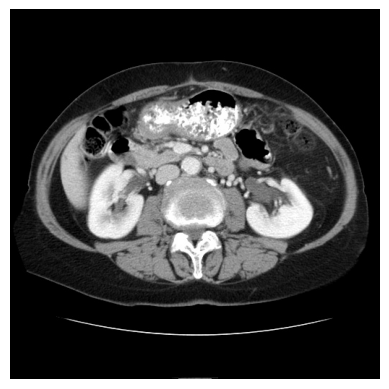

Question: Does the picture contain heart?
Actual Answer: No
Predicted Answer: No


In [ ]:
# Select a sample from the validation dataset
sample_idx = 122  # Change this index to select a different sample
sample = val_data[sample_idx]

image = sample['image']
question = sample['question']
# question = "what modality is this?" #For custom question
actual_answer = sample['answer']

# Perform inference
predicted_answer = inference(model, image, question, gpt2_tokenizer, device)

# Display the result
display_result(image, question, actual_answer, predicted_answer)

## Accuracy Calculation

In [ ]:
# Accuracy of Test Set (SLAKE)
def compute_accuracy(model, data_loader, tokenizer, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in tqdm(data_loader):
            images, question_tokens, answer_tokens = batch
            images = images.to(device)
            question_tokens = question_tokens.to(device)
            answer_tokens = answer_tokens.to(device)

            outputs, _ = model(question_tokens, images)
            predicted_token_ids = torch.argmax(outputs, dim=-1)

            for pred, actual in zip(predicted_token_ids, answer_tokens):
                predicted_answer = tokenizer.decode(pred, skip_special_tokens=True)
                actual_answer = tokenizer.decode(actual, skip_special_tokens=True)

                if predicted_answer.strip() == actual_answer.strip():
                    correct += 1
                total += 1

    accuracy = correct / total
    return accuracy

# Compute accuracy on the validation set
accuracy = compute_accuracy(model, test_loader, gpt2_tokenizer, device)
print(f'Test Set Accuracy: {accuracy * 100:.2f}%')

100%|██████████| 67/67 [00:28<00:00,  2.32it/s]

Validation Accuracy: 28.09%


In [ ]:
# Accuracy of Validation Set (SLAKE)
def compute_accuracy(model, data_loader, tokenizer, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in tqdm(data_loader):
            images, question_tokens, answer_tokens = batch
            images = images.to(device)
            question_tokens = question_tokens.to(device)
            answer_tokens = answer_tokens.to(device)

            outputs, _ = model(question_tokens, images)
            predicted_token_ids = torch.argmax(outputs, dim=-1)

            for pred, actual in zip(predicted_token_ids, answer_tokens):
                predicted_answer = tokenizer.decode(pred, skip_special_tokens=True)
                actual_answer = tokenizer.decode(actual, skip_special_tokens=True)

                if predicted_answer.strip() == actual_answer.strip():
                    correct += 1
                total += 1

    accuracy = correct / total
    return accuracy

# Compute accuracy on the validation set
accuracy = compute_accuracy(model, val_loader, gpt2_tokenizer, device)
print(f'Validation Set Accuracy: {accuracy * 100:.2f}%')

100%|██████████| 66/66 [00:26<00:00,  2.46it/s]

Validation Accuracy: 26.78%


In [ ]:
# Accuracy of Train Set (SLAKE)
def compute_accuracy(model, data_loader, tokenizer, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in tqdm(data_loader):
            images, question_tokens, answer_tokens = batch
            images = images.to(device)
            question_tokens = question_tokens.to(device)
            answer_tokens = answer_tokens.to(device)

            outputs, _ = model(question_tokens, images)
            predicted_token_ids = torch.argmax(outputs, dim=-1)

            for pred, actual in zip(predicted_token_ids, answer_tokens):
                predicted_answer = tokenizer.decode(pred, skip_special_tokens=True)
                actual_answer = tokenizer.decode(actual, skip_special_tokens=True)

                if predicted_answer.strip() == actual_answer.strip():
                    correct += 1
                total += 1

    accuracy = correct / total
    return accuracy

# Compute accuracy on the validation set
accuracy = compute_accuracy(model, train_loader, gpt2_tokenizer, device)
print(f'Train Set Accuracy: {accuracy * 100:.2f}%')

100%|██████████| 308/308 [01:32<00:00,  3.32it/s]

Validation Accuracy: 29.68%


# VGG - BioGPT

First install required library and import them

In [2]:
!pip install sacremoses -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 8.9 MB/s eta 0:00:00


In [3]:
# Import required packages
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BioGptForCausalLM, BioGptTokenizer
from torchvision import models
from datasets import load_dataset
import torchvision.transforms as transforms
import torch.optim as optim
from torch.nn.functional import cross_entropy
import matplotlib.pyplot as plt
from tqdm import tqdm

## Dataset Handling

In [4]:
# Initialize tokenizer and set padding token
biogpt_tokenizer = BioGptTokenizer.from_pretrained('microsoft/biogpt')
biogpt_tokenizer.pad_token = biogpt_tokenizer.eos_token

# Image transformations
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # VGG requires 224x224 images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom Dataset class
class DatasetProcessing(Dataset):
    def __init__(self, dataset, tokenizer, transform=None):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample = self.dataset[idx]
        image = sample['image']  # Assume this is already a PIL.Image object
        question = sample['question']
        answer = sample['answer']

        # Ensure image is in RGB format
        if image.mode != 'RGB':
            image = image.convert('RGB')

        if self.transform:
            image = self.transform(image)

        # Tokenize the question
        question_inputs = self.tokenizer(question, return_tensors="pt", padding='max_length', truncation=True, max_length=30)
        question_input_ids = question_inputs['input_ids'].squeeze(0)

        # Tokenize the answer
        answer_inputs = self.tokenizer(answer, return_tensors="pt", padding='max_length', truncation=True, max_length=30)
        answer_input_ids = answer_inputs['input_ids'].squeeze(0)

        return image, question_input_ids, answer_input_ids

# # Load dataset
# dataset = load_dataset("mdwiratathya/SLAKE-vqa-english")
# train_data = dataset['train']
# val_data = dataset['validation']
# test_data = dataset['test']

# # Create DataLoader
# train_dataset = DatasetProcessing(train_data, biogpt_tokenizer, image_transform)
# train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# val_dataset = DatasetProcessing(val_data, biogpt_tokenizer, image_transform)
# val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# test_dataset = DatasetProcessing(test_data, biogpt_tokenizer, image_transform)
# test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# VQA-RAD Dataset only has train and test set. If you want to use VQA-RAD dataset, use this section instead.
# Load VQA-RAD dataset
dataset = load_dataset("flaviagiammarino/vqa-rad")
train_data = dataset['train']
val_data = dataset['test']

# Create DataLoader
train_dataset = DatasetProcessing(train_data, biogpt_tokenizer, image_transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = DatasetProcessing(val_data, biogpt_tokenizer, image_transform)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json:   0%|          | 0.00/927k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/696k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/595 [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1793 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/451 [00:00<?, ? examples/s]

## Model Architecture Definition

Referenced from https://github.com/ab3llini/Transformer-VQA, changing GPT2 into BioGPT

In [5]:
class CoAttention(nn.Module):
    def __init__(self, map_dim, hidden_dim, attention_dim=512):
        """
        :param map_dim: Number of maps (i.e. channels) in the used CNN. Usually map_dim = maps.shape[-1]
        :param hidden_dim: Size of  hidden layer of the language model. Usually hidden_size = hiddens.shape[-1]
        :param attention_dim: Dimension of the attention layers
        """
        super(CoAttention, self).__init__()
        self.map_dim = map_dim
        self.hidden_dim = hidden_dim
        self.attention_dim = attention_dim

        self.map_linear = nn.Linear(in_features=self.map_dim, out_features=self.attention_dim)
        self.hidden_linear = nn.Linear(in_features=self.hidden_dim, out_features=self.attention_dim)
        self.co_att_linear = nn.Linear(in_features=self.attention_dim, out_features=self.hidden_dim)
        self.rectified_linear = nn.Linear(in_features=self.attention_dim, out_features=1)
        self.pixel_softmax = nn.Softmax(dim=2)

        self.rectify = nn.ReLU()

    def forward(self, maps, hiddens):
        batch_size = maps.size(0)
        flattened_maps = maps.view(batch_size, -1, self.map_dim)
        map_linear_out = self.map_linear(flattened_maps)
        hidden_linear_out = self.hidden_linear(hiddens)
        map_linear_out = map_linear_out.unsqueeze(1)
        hidden_linear_out = hidden_linear_out.unsqueeze(2)
        pointwise_sum = map_linear_out + hidden_linear_out
        rectified_sum = self.rectify(pointwise_sum)
        rectified_linear_out = self.rectified_linear(rectified_sum).squeeze(3)
        pixel_softmax_out = self.pixel_softmax(rectified_linear_out)
        pointwise_mul = flattened_maps.unsqueeze(1) * pixel_softmax_out.unsqueeze(3)
        pointwise_mul = pointwise_mul.sum(dim=2)
        co_att_linear_out = self.co_att_linear(pointwise_mul)
        co_att_out = co_att_linear_out * hiddens

        return co_att_out, pixel_softmax_out

class VGGEncoder(nn.Module):

    def __init__(self, instance=models.vgg11(pretrained=True)):
        super(VGGEncoder, self).__init__()

        # Using pre-trained vgg
        vgg = instance

        # Remove the classifier
        modules = list(vgg.children())[:-1]

        # Keep only the network
        self.vgg = nn.Sequential(*modules)

    def forward(self, images):
        # outputs maps from vgg (512 channels average pooled @ 7x7)
        out = self.vgg(images)  # (batch_size, 512, 7, 7)
        return out.permute(0, 2, 3, 1)  # (batch_size, 7, 7, 512)


class ResNetEncoder(nn.Module):

    def __init__(self, encoded_image_size=14, instance=models.resnet101(pretrained=True)):
        super(ResNetEncoder, self).__init__()
        self.enc_image_size = encoded_image_size

        # Remove linear and pool layers (since we're not doing classification)
        modules = list(instance.children())[:-2]
        self.resnet = nn.Sequential(*modules)

        # Resize image to fixed size to allow input images of variable size
        self.adaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size))

    def forward(self, images):
        """
        Forward propagation.

        :param images: images, a tensor of dimensions (batch_size, 3, image_size, image_size)
        :return: encoded images
        """
        out = self.resnet(images)  # (batch_size, 2048, image_size/32, image_size/32)
        out = self.adaptive_pool(out)  # (batch_size, 2048, encoded_image_size, encoded_image_size)
        out = out.permute(0, 2, 3, 1)  # (batch_size, encoded_image_size, encoded_image_size, 2048)
        return out

class ModularBioGpt(nn.Module):
    def __init__(self, emd_size=None):
        super(ModularBioGpt, self).__init__()

        biogpt = BioGptForCausalLM.from_pretrained('microsoft/biogpt')
        if emd_size:
            biogpt.resize_token_embeddings(emd_size)

        self.head = list(biogpt.children())[1]
        self.biogpt = list(biogpt.children())[0]

    def show_params(self):
        for name, param in self.named_parameters():
            if param.requires_grad:
                print('Trainable : TRUE ->', name)
            else:
                print('Trainable : FALSE ->', name)

        print('Trainable parameters: {}'.format(sum(p.numel() for p in self.parameters() if p.requires_grad)))
        print('Total parameters: {}'.format(sum(p.numel() for p in self.parameters())))

    def forward(self, sequence):
        return self.head(self.biogpt(sequence)[0])

class VGGBioGPT(ModularBioGpt):
    def __init__(self):
        super(VGGBioGPT, self).__init__()

        self.image_encoder = VGGEncoder(models.vgg19(pretrained=True))
        self.co_att = CoAttention(512, 1024, 512)
        self.classifier = nn.Linear(in_features=2048, out_features=self.biogpt.config.vocab_size)

        for p in self.image_encoder.parameters():
            p.requires_grad = False
        for p in self.biogpt.parameters():
            p.requires_grad = False

        for p in self.classifier.parameters():
            p.requires_grad = True
        for p in self.co_att.parameters():
            p.requires_grad = True

    def forward(self, sequence, image):
        maps = self.image_encoder(image)
        hiddens = self.biogpt(sequence)[0]
        co_att_out, pixel_softmax_out = self.co_att(maps, hiddens)
        concat = torch.cat([hiddens, co_att_out], dim=2)
        return self.classifier(concat), pixel_softmax_out

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:06<00:00, 83.8MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future.

## Training Loop

In [6]:
!pip install wandb -q
import wandb
wandb.login()

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="VQA-MED",

    # track hyperparameters and run metadata
    config={
    "learning_rate": 1e-4,
    "architecture": "VGG-BioGPT",
    "dataset": "SLAKE",
    "epochs": 6,
    }
)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.6/289.6 kB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.0 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mdwiratathya (tekfis20). Use `wandb login --relogin` to force relogin


In [7]:
# # Device configuration
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # Initialize model
# model = VGGBioGPT()
# model = model.to(device)  # Move model to GPU if available

# # Optimizer
# optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

# # Training function
# def train_epoch(model, data_loader, optimizer, device):
#     model.train()
#     total_loss = 0
#     for batch in data_loader:
#         images, question_tokens, answer_tokens = batch
#         images = images.to(device)
#         question_tokens = question_tokens.to(device)
#         answer_tokens = answer_tokens.to(device)

#         optimizer.zero_grad()
#         outputs, _ = model(question_tokens, images)

#         loss = cross_entropy(outputs.view(-1, outputs.size(-1)), answer_tokens.view(-1))
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()

#     return total_loss / len(data_loader)

# # Validation function
# def validate_epoch(model, data_loader, device):
#     model.eval()
#     total_loss = 0
#     with torch.no_grad():
#         for batch in data_loader:
#             images, question_tokens, answer_tokens = batch
#             images = images.to(device)
#             question_tokens = question_tokens.to(device)
#             answer_tokens = answer_tokens.to(device)

#             outputs, _ = model(question_tokens, images)
#             loss = cross_entropy(outputs.view(-1, outputs.size(-1)), answer_tokens.view(-1))

#             total_loss += loss.item()

#     return total_loss / len(data_loader)

# # Test function
# def test_epoch(model, data_loader, device):
#     model.eval()
#     total_loss = 0
#     with torch.no_grad():
#         for batch in data_loader:
#             images, question_tokens, answer_tokens = batch
#             images = images.to(device)
#             question_tokens = question_tokens.to(device)
#             answer_tokens = answer_tokens.to(device)

#             outputs, _ = model(question_tokens, images)
#             loss = cross_entropy(outputs.view(-1, outputs.size(-1)), answer_tokens.view(-1))

#             total_loss += loss.item()

#     return total_loss / len(data_loader)

# # Training loop
# num_epochs = 6
# checkpoint_path = "vggbiogpt_slake.pth"

# for epoch in range(num_epochs):
#     train_loss = train_epoch(model, train_loader, optimizer, device)
#     val_loss = validate_epoch(model, val_loader, device)

#     wandb.log({"train loss": train_loss, "validation loss": val_loss})

#     print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}')

#     # Save the model every 2 epochs
#     if (epoch + 1) % 2 == 0:
#         torch.save({
#             'epoch': epoch + 1,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'train_loss': train_loss,
#             'val_loss': val_loss,
#         }, checkpoint_path)

# # Test evaluation after training is complete
# test_loss = test_epoch(model, test_loader, device)
# wandb.log({"test loss": test_loss})
# print(f'Test Loss: {test_loss}')

# wandb.finish()


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model
model = VGGBioGPT()
model = model.to(device)  # Move model to GPU if available

# Optimizer
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

# Training function
def train_epoch(model, data_loader, optimizer, device):
    model.train()
    total_loss = 0
    for batch in data_loader:
        images, question_tokens, answer_tokens = batch
        images = images.to(device)
        question_tokens = question_tokens.to(device)
        answer_tokens = answer_tokens.to(device)

        optimizer.zero_grad()
        outputs, _ = model(question_tokens, images)

        loss = cross_entropy(outputs.view(-1, outputs.size(-1)), answer_tokens.view(-1))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)

# Validation function
def validate_epoch(model, data_loader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in data_loader:
            images, question_tokens, answer_tokens = batch
            images = images.to(device)
            question_tokens = question_tokens.to(device)
            answer_tokens = answer_tokens.to(device)

            outputs, _ = model(question_tokens, images)
            loss = cross_entropy(outputs.view(-1, outputs.size(-1)), answer_tokens.view(-1))

            total_loss += loss.item()

    return total_loss / len(data_loader)

# Training loop
num_epochs = 6
checkpoint_path = "vgggpt2_slake.pth"

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, device)
    val_loss = validate_epoch(model, val_loader, device)

    wandb.log({"train loss": train_loss, "validation loss": val_loss})

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}')

    # Save the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
        }, checkpoint_path)

wandb.finish()

pytorch_model.bin:   0%|          | 0.00/1.56G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:09<00:00, 62.7MB/s]


Epoch 1/6, Train Loss: 2.8590245945791226, Val Loss: 0.532155468546111
Epoch 2/6, Train Loss: 0.4527884368677582, Val Loss: 0.4382981318851997
Epoch 3/6, Train Loss: 0.34968117861884884, Val Loss: 0.41479641301878567
Epoch 4/6, Train Loss: 0.29255766711667575, Val Loss: 0.4092109298397755
Epoch 5/6, Train Loss: 0.2510653630525401, Val Loss: 0.40769127396673993
Epoch 6/6, Train Loss: 0.21872757774143092, Val Loss: 0.40954060184544533


train loss,█▂▁▁▁▁
validation loss,█▃▁▁▁▁
train loss,0.21873
validation loss,0.40954


Weight and Bias inizialitation to monitor training progress

In [ ]:
!pip install wandb -q
import wandb
wandb.login()

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="VQA-MED",

    # track hyperparameters and run metadata
    config={
    "learning_rate": 1e-4,
    "architecture": "VGG-BioGPT",
    "dataset": "SLAKE",
    "epochs": 6,
    }
)

Training loop for SLAKE dataset, use the uncomment section if train using VQA-RAD

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model
model = VGGBioGPT()
model = model.to(device)  # Move model to GPU if available

# Optimizer
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

# Training function
def train_epoch(model, data_loader, optimizer, device):
    model.train()
    total_loss = 0
    for batch in data_loader:
        images, question_tokens, answer_tokens = batch
        images = images.to(device)
        question_tokens = question_tokens.to(device)
        answer_tokens = answer_tokens.to(device)

        optimizer.zero_grad()
        outputs, _ = model(question_tokens, images)

        loss = cross_entropy(outputs.view(-1, outputs.size(-1)), answer_tokens.view(-1))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)

# Validation function
def validate_epoch(model, data_loader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in data_loader:
            images, question_tokens, answer_tokens = batch
            images = images.to(device)
            question_tokens = question_tokens.to(device)
            answer_tokens = answer_tokens.to(device)

            outputs, _ = model(question_tokens, images)
            loss = cross_entropy(outputs.view(-1, outputs.size(-1)), answer_tokens.view(-1))

            total_loss += loss.item()

    return total_loss / len(data_loader)

# Test function
def test_epoch(model, data_loader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in data_loader:
            images, question_tokens, answer_tokens = batch
            images = images.to(device)
            question_tokens = question_tokens.to(device)
            answer_tokens = answer_tokens.to(device)

            outputs, _ = model(question_tokens, images)
            loss = cross_entropy(outputs.view(-1, outputs.size(-1)), answer_tokens.view(-1))

            total_loss += loss.item()

    return total_loss / len(data_loader)

# Training loop
num_epochs = 6
checkpoint_path = "vggbiogpt_slake.pth"

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, device)
    val_loss = validate_epoch(model, val_loader, device)

    wandb.log({"train loss": train_loss, "validation loss": val_loss})

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}')

    # Save the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
        }, checkpoint_path)

# Test evaluation after training is complete
test_loss = test_epoch(model, test_loader, device)
wandb.log({"test loss": test_loss})
print(f'Test Loss: {test_loss}')

wandb.finish()


# # Device configuration
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # Initialize model
# model = VGGBioGPT()
# model = model.to(device)  # Move model to GPU if available

# # Optimizer
# optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

# # Training function
# def train_epoch(model, data_loader, optimizer, device):
#     model.train()
#     total_loss = 0
#     for batch in data_loader:
#         images, question_tokens, answer_tokens = batch
#         images = images.to(device)
#         question_tokens = question_tokens.to(device)
#         answer_tokens = answer_tokens.to(device)

#         optimizer.zero_grad()
#         outputs, _ = model(question_tokens, images)

#         loss = cross_entropy(outputs.view(-1, outputs.size(-1)), answer_tokens.view(-1))
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()

#     return total_loss / len(data_loader)

# # Validation function
# def validate_epoch(model, data_loader, device):
#     model.eval()
#     total_loss = 0
#     with torch.no_grad():
#         for batch in data_loader:
#             images, question_tokens, answer_tokens = batch
#             images = images.to(device)
#             question_tokens = question_tokens.to(device)
#             answer_tokens = answer_tokens.to(device)

#             outputs, _ = model(question_tokens, images)
#             loss = cross_entropy(outputs.view(-1, outputs.size(-1)), answer_tokens.view(-1))

#             total_loss += loss.item()

#     return total_loss / len(data_loader)

# # Training loop
# num_epochs = 6
# checkpoint_path = "vgggpt2_slake.pth"

# for epoch in range(num_epochs):
#     train_loss = train_epoch(model, train_loader, optimizer, device)
#     val_loss = validate_epoch(model, val_loader, device)

#     wandb.log({"train loss": train_loss, "validation loss": val_loss})

#     print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}')

#     # Save the model every 2 epochs
#     if (epoch + 1) % 2 == 0:
#         torch.save({
#             'epoch': epoch + 1,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'train_loss': train_loss,
#             'val_loss': val_loss,
#         }, checkpoint_path)

# wandb.finish()

pytorch_model.bin:   7%|6         | 105M/1.56G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/6, Train Loss: 1.1450733594451246, Val Loss: 0.24042905234929288
Epoch 2/6, Train Loss: 0.19160870631987398, Val Loss: 0.17719353983799616
Epoch 3/6, Train Loss: 0.15412780065573267, Val Loss: 0.15201391832846584
Epoch 4/6, Train Loss: 0.13597501019717423, Val Loss: 0.14264805671392064
Epoch 5/6, Train Loss: 0.12412224072575956, Val Loss: 0.13460245914757252
Epoch 6/6, Train Loss: 0.11576556753028523, Val Loss: 0.13028742711652408
Test Loss: 0.1299793595142329


test loss,▁
train loss,█▂▁▁▁▁
validation loss,█▄▂▂▁▁
test loss,0.12998
train loss,0.11577
validation loss,0.13029


## Inference

In [ ]:
# Function to generate the predicted answer
def inference(model, image, question, tokenizer, device):
    model.eval()
    with torch.no_grad():
        # Ensure image is in RGB format
        if image.mode != 'RGB':
            image = image.convert('RGB')

        # Apply image transformations
        image = image_transform(image).unsqueeze(0).to(device)

        # Tokenize the question
        question_inputs = tokenizer(question, return_tensors="pt", padding='max_length', truncation=True, max_length=30)
        question_input_ids = question_inputs['input_ids'].to(device)

        # Get the model output
        outputs, _ = model(question_input_ids, image)

        # Convert the output logits to predicted token IDs
        predicted_token_ids = torch.argmax(outputs, dim=-1)

        # Decode the predicted token IDs to get the predicted answer
        predicted_answer = tokenizer.decode(predicted_token_ids[0], skip_special_tokens=True)

    return predicted_answer

# Function to display the image, question, actual answer, and predicted answer
def display_result(image, question, actual_answer, predicted_answer):
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    print(f"Question: {question}")
    print(f"Actual Answer: {actual_answer}")
    print(f"Predicted Answer: {predicted_answer}")

In [ ]:
# Select a sample from the validation dataset
sample_idx = 122  # Change this index to select a different sample
sample = val_data[sample_idx]

image = sample['image']
question = sample['question']
# question = "what modality is this?"
actual_answer = sample['answer']

# Perform inference
predicted_answer = inference(loadmodel, image, question, gpt2_tokenizer, device)

# Display the result
display_result(image, question, actual_answer, predicted_answer)

## Accuracy Calculation

In [8]:
def compute_accuracy(model, data_loader, tokenizer, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in tqdm(data_loader):
            images, question_tokens, answer_tokens = batch
            images = images.to(device)
            question_tokens = question_tokens.to(device)
            answer_tokens = answer_tokens.to(device)

            outputs, _ = model(question_tokens, images)
            predicted_token_ids = torch.argmax(outputs, dim=-1)

            for pred, actual in zip(predicted_token_ids, answer_tokens):
                predicted_answer = tokenizer.decode(pred, skip_special_tokens=True)
                actual_answer = tokenizer.decode(actual, skip_special_tokens=True)

                if predicted_answer.strip() == actual_answer.strip():
                    correct += 1
                total += 1

    accuracy = correct / total
    return accuracy

In [9]:
# Evaluation for VQA RAD dataset
# Compute accuracy on the test set
accuracy = compute_accuracy(model, val_loader, biogpt_tokenizer, device)
print(f'Test Set Accuracy: {accuracy * 100:.2f}%')

# Compute accuracy on the train set
accuracy = compute_accuracy(model, train_loader, biogpt_tokenizer, device)
print(f'Train Set Accuracy: {accuracy * 100:.2f}%')

100%|██████████| 29/29 [00:10<00:00,  2.73it/s]


Test Set Accuracy: 33.26%


100%|██████████| 113/113 [00:42<00:00,  2.64it/s]

Train Set Accuracy: 40.44%


In [ ]:
# Evaluation for SLAKE dataset
# Compute accuracy on the test set
accuracy = compute_accuracy(model, test_loader, biogpt_tokenizer, device)
print(f'Test Set Accuracy: {accuracy * 100:.2f}%')

# Compute accuracy on the validation set
accuracy = compute_accuracy(model, val_loader, biogpt_tokenizer, device)
print(f'Validation Set Accuracy: {accuracy * 100:.2f}%')

# Compute accuracy on the train set
accuracy = compute_accuracy(model, train_loader, biogpt_tokenizer, device)
print(f'Train Set Accuracy: {accuracy * 100:.2f}%')